In [1]:
import torch
import torch.optim as optim
from torch.optim import lr_scheduler

import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader

import torchvision
from torchvision import datasets, models, transforms
import copy

import numpy as np
import pandas as pd

%matplotlib inline 
import matplotlib.pyplot as plt
import time
import os
import copy
import random
import math

import scipy.stats as stats

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.mixture import GaussianMixture

from skimage.filters import sobel
from skimage.color import rgb2gray

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

print(device)

cuda:0


In [2]:
x = np.load("data/x_train_b.npy")
y = np.load("data/y_train_b.npy")

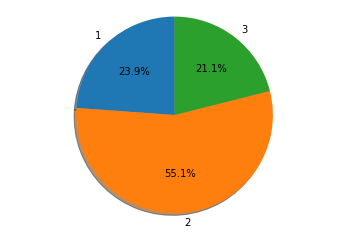

In [3]:
import matplotlib.pyplot as plt

percentages= [np.count_nonzero(y==0),
              np.count_nonzero(y==1),
              np.count_nonzero(y==2)]
              
fig1, ax1 = plt.subplots()
ax1.pie(percentages,labels=["1","2","3"], autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  

plt.show()

In [4]:
def auto_crop(image, target_width, target_height):
  edges = sobel(rgb2gray(image))
  # plt.plot(np.sum(edges, axis=1))
  # plt.show()
  columns = np.sum(edges, axis=0)
  mixture = GaussianMixture(2, covariance_type='spherical')
  mixture.fit(columns.reshape(-1, 1))
  print(mixture.covariances_)
  
  min = np.amin(columns)
  max = np.amax(columns)
  x = np.linspace(min, max, 500)
  y0 = stats.norm.pdf(x, mixture.means_[0], mixture.covariances_[0])
  y1 = stats.norm.pdf(x, mixture.means_[1], mixture.covariances_[1])
  plt.hist(columns, bins=np.arange(min, max + 0.05, 0.05), density=True)
  plt.plot(x, y0)
  plt.plot(x, y1)
  plt.show()
  plt.plot(columns)
  plt.show()
  print(edges.shape)
  return edges

(285, 4, 200, 1024, 3)


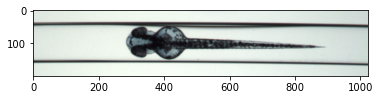

[1.88479906 0.06988751]


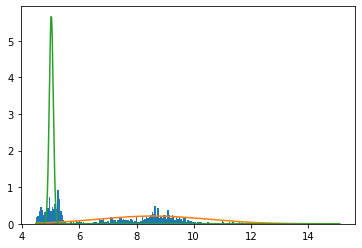

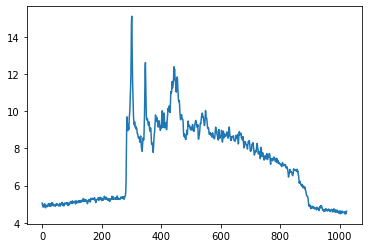

(200, 1024)


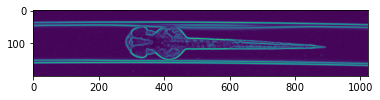

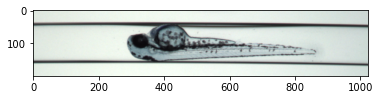

[2.76689112 0.06418598]


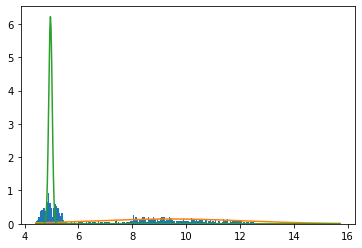

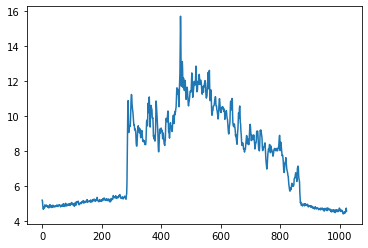

(200, 1024)


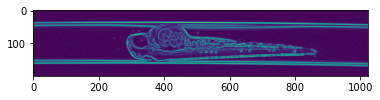

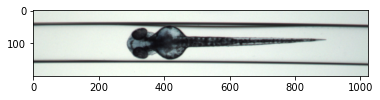

[1.56161583 0.07129758]


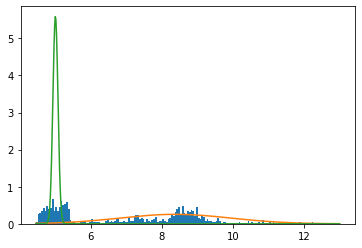

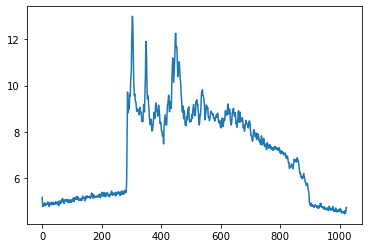

(200, 1024)


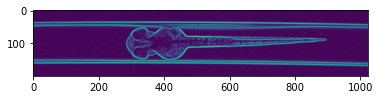

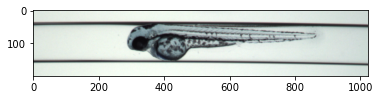

[0.06461788 2.43922912]


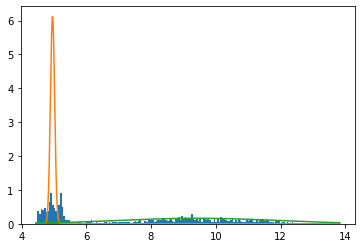

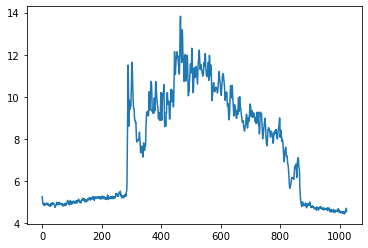

(200, 1024)


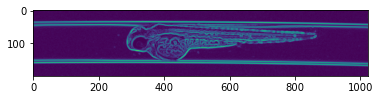

In [5]:
# crop image
index = random.randrange(len(x))
print(x.shape)
for i in range(4):
  plt.imshow(x[index][i])
  plt.show()
  plt.imshow(auto_crop(x[index][i], 180, 1000))
  plt.show()

In [6]:
tensor_x = torch.Tensor(x) 
tensor_y = torch.Tensor(y).long()

tensor_x = torch.swapaxes(tensor_x,2,4)
tensor_x = torch.swapaxes(tensor_x,3,4)

x_train,x_test,y_train,y_test = train_test_split(tensor_x,tensor_y,test_size=0.1)

print("x train shape: ", x_train.shape,"x test shape: ",x_test.shape)

train_ds = TensorDataset(x_train,nn.functional.one_hot(y_train,3)) 
test_ds = TensorDataset(x_test,nn.functional.one_hot(y_test,3)) 

train_dl = DataLoader(train_ds,2,shuffle = True)
test_dl = DataLoader(test_ds,2,drop_last = True)
del x,y

x train shape:  torch.Size([256, 4, 3, 200, 1024]) x test shape:  torch.Size([29, 4, 3, 200, 1024])


In [7]:
# fig, (ax1, ax2) = plt.subplots(1, 2)
# fig.suptitle('subplots')

# percentages1 = [np.count_nonzero(y==0),
#               np.count_nonzero(y==1),
#               np.count_nonzero(y==2)]

# percentages1 = [np.count_nonzero(y==0),
#               np.count_nonzero(y==1),
#               np.count_nonzero(y==2)]
              

# ax1.pie(percentages,labels=["1","2","3"], autopct='%1.1f%%',
#         shadow=True, startangle=90)
# ax2.pie(percentages,labels=["1","2","3"], autopct='%1.1f%%',
#         shadow=True, startangle=90)



              
# fig1, ax1 = plt.subplots()
# ax1.pie(percentages,labels=["1","2","3"], autopct='%1.1f%%',
#         shadow=True, startangle=90)
# ax1.axis('equal')  

# plt.show()

In [8]:
model = torchvision.models.resnet18(pretrained=True)
#print(list(model.parameters())[0][0][0])
model = nn.Sequential(*list(model.children())[:-1])
# list(model.children())
#print(list(model.parameters())[0][0][0])

In [9]:
def reluToInplaceFalse(model):
  for name, child in model.named_children():
    if isinstance(child, nn.ReLU):
      setattr(child, 'inplace', False)
    else:
      reluToInplaceFalse(child)

In [10]:
from torchvision.transforms.transforms import RandomRotation

class Classifier(torch.nn.Module):

  def __init__(self, backbone='resnet', multi_backbone = True, device ="cuda:0",dropout_rate = 0.2, do_augmentation = False):
    super().__init__()
    self.multi_backbone = multi_backbone

    if backbone == "vgg19":
      backbone = torchvision.models.vgg19(pretrained=True)
      self.out_channels = 25088
      
    elif backbone == "resnet18":
      backbone = torchvision.models.resnet18(pretrained=True)
      self.out_channels = 512

    elif backbone == "resnet50":
      backbone = torchvision.models.resnet50(pretrained=True)
      self.out_channels = 2048

    elif backbone == "Efficientnet b1":
      backbone = torchvision.models.efficientnet_b1(pretrained=True)
      self.out_channels = 1280

    elif backbone == "Efficientnet b3":
      backbone = torchvision.models.efficientnet_b3(pretrained=True)
      self.out_channels = 1536

    elif backbone == "Efficientnet b5":
      backbone = torchvision.models.efficientnet_b5(pretrained=True)
      self.out_channels = 2048

    elif backbone == "Efficientnet b7":
      backbone = torchvision.models.efficientnet_b7(pretrained=True)
      self.out_channels = 2560
      
    # Disabling inplace ReLu becasuse GradCam doesn't work it enabled
    reluToInplaceFalse(backbone)
     
    modules = list(backbone.children())[:-1]
    self.do_augmentation = do_augmentation

    if self.do_augmentation:
      self.augmentation = nn.Sequential(transforms.RandomHorizontalFlip(),
                                        transforms.RandomVerticalFlip(),
                                        transforms.RandomPerspective(0.2),
                                        RandomRotation(20),
                                        transforms.RandomAutocontrast())

    if self.multi_backbone:
      self.backbone1 = nn.Sequential(*copy.deepcopy(modules)).to(device)
      self.backbone2 = nn.Sequential(*copy.deepcopy(modules)).to(device)
      self.backbone3 = nn.Sequential(*copy.deepcopy(modules)).to(device)
      self.backbone4 = nn.Sequential(*copy.deepcopy(modules)).to(device)
    else:
      self.backbone =  nn.Sequential(*modules).to(device)


     

    self.fc1 = nn.Sequential(nn.Dropout(dropout_rate),
                              nn.Linear(self.out_channels, 128),
                              nn.ReLU(),
                              nn.Dropout(dropout_rate)) #TODO: Experiment with BN and Dropout

    self.fc = nn.Sequential(nn.Linear(512, 3))                  #TODO: L2 Regularization
     
  def forward(self, x, is_training = True):
    if self.do_augmentation and is_training:
      imgs = [self.augmentation(x[:,i]) for i in range(4)] #list of 4 images
    else:
      imgs = [x[:,i] for i in range(4)] #list of 4 images

    if self.multi_backbone:
      encodings = [self.fc1(torch.flatten(self.backbone1(imgs[0]),1)),
                   self.fc1(torch.flatten(self.backbone2(imgs[1]),1)),
                   self.fc1(torch.flatten(self.backbone3(imgs[2]),1)),
                   self.fc1(torch.flatten(self.backbone4(imgs[3]),1))]
    else:
      encodings = [self.fc1(self.backbone(img).squeeze()) for img in imgs]

    return self.fc(torch.cat(encodings,1))


In [11]:
def freeze_layers(model,layers = 5):
  if model.multi_backbone:
    for i,param in enumerate(model.backbone1.parameters()):
      if i < layers:
        param.requires_grad = False

    for i,param in enumerate(model.backbone2.parameters()):
      if i < layers:
        param.requires_grad = False

    for i,param in enumerate(model.backbone3.parameters()):
      if i < layers:
        param.requires_grad = False

    for i,param in enumerate(model.backbone4.parameters()):
      if i < layers:
        param.requires_grad = False
  else:
     for i,param in enumerate(model.backbone.parameters()):
      if i < layers:
        param.requires_grad = False



In [12]:
from torch.utils.tensorboard import SummaryWriter
from tqdm import tqdm

def train_model(model, train_dl, test_dl, optimizer, evaluation_steps = 20, epochs =1, savefile='model.pt'):
  writer = SummaryWriter()

  EPOCHS = epochs
  DATA_SIZE =  {"train":len(train_dl.dataset),"eval":len(test_dl.dataset)}

  best_eval_acc = 0
  best_eval_acc_step = 0
  
  best_eval_loss = float('inf')
  best_eval_loss_step = 0

  final_eval_loss = 0
  final_eval_acc = 0

  final_train_loss = 0
  final_train_acc = 0




  exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)
  criterion = nn.BCEWithLogitsLoss()

  step =0

  for epoch in range(EPOCHS):
        running_loss = 0.0
        running_corrects = 0

        # Iterate over data.
        for inputs, labels in train_dl:
          optimizer.zero_grad()
          step += 1
          model.train()
          inputs = inputs.to(device)
          labels = labels.to(device)
          outputs = model(inputs)

          _, preds = torch.max(outputs, 1)
          loss = criterion(outputs, labels.squeeze(1).float())
          loss.backward()
          optimizer.step()

          # statistics
          running_loss += loss.item() * inputs.size(0)
          running_corrects += torch.sum(preds == torch.argmax(labels,2).squeeze().data)
          # if phase == 'train':
          #     scheduler.step()
          if step % evaluation_steps == 0:
            test_running_loss = 0.0
            test_running_corrects = 0
            model.eval()
            with torch.no_grad():
              for inputs, labels in test_dl:
                inputs = inputs.to(device)
                labels = labels.to(device)
                outputs = model(inputs,is_training=False)
                loss = criterion(outputs, labels.squeeze(1).float())
                _, preds = torch.max(outputs, 1)


                test_running_loss += loss.item() * inputs.size(0)
                test_running_corrects += torch.sum(preds == torch.argmax(labels,2).squeeze().data)

            eval_loss = test_running_loss / DATA_SIZE["eval"]
            eval_acc = test_running_corrects.double() / DATA_SIZE["eval"]

            writer.add_scalar('Loss/'+"eval", eval_loss, step)
            writer.add_scalar('Accuracy/'+"eval", eval_acc, step)

            final_eval_loss = eval_loss
            final_eval_acc = eval_acc

            if eval_loss < best_eval_loss:
              best_eval_loss = eval_loss
              best_eval_loss_step = step
              torch.save(model, savefile)
              print('saved model')

            if eval_acc > best_eval_acc:
              best_eval_acc = eval_acc
              best_eval_acc_step = step

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
            "Eval", eval_loss, eval_acc))



        epoch_loss = running_loss / DATA_SIZE["train"]
        epoch_acc = running_corrects.double() / DATA_SIZE["train"]


        final_train_loss = epoch_loss
        final_train_acc = epoch_acc

        print('Epoch {}/{} '.format(epoch+1, EPOCHS ),'{} Loss: {:.4f} Acc: {:.4f}'.format(
              "Train", epoch_loss, epoch_acc))
          
        writer.add_scalar('Loss/'+"Train", epoch_loss, step)
        writer.add_scalar('Accuracy/'+"Train", epoch_acc, step)

  # print('Best val Acc: {:4f}\n\n'.format(best_eval_acc))

  return {  "Best Eval Acc": best_eval_acc.cpu().item(),
            "Best Eval Loss": best_eval_loss,
            "Best Eval Step": best_eval_loss_step,
            "Final Train Acc": final_train_acc.cpu().item(),
            "Final Eval Acc": final_eval_acc.cpu().item(),
            "Final Train Loss": final_train_loss,
            "Final Eval Loss": final_eval_loss,
        }
# load best model weights
# model.load_state_dict(best_model_wts)


In [13]:

Sweep_Summary = {
    "Backbone" : [],
    "Optim" : [],
    "LR" : [],
    "Scheduler" : [],
    "Epochs" : [],
    "Batch Size" : [],
    "Dropout": [],
    "Augmentation": [],
    "Weight Decay": [],
    "Freeze Layers": [],
    "Best Eval Loss": [],
    "Best Eval Step": [],
    "Best Eval Acc": [],
    "Final Train Acc": [],
    "Final Eval Acc": [],
    "Final Train Loss": [],
    "Final Eval Loss": [],

}

BACKBONE = "resnet18"
OPTIM = "Adam"
LR = 2e-5
SCHEDULER = "None"
EPOCHS = 35
BATCHSIZE = 2
DROPOUT = [0,0.2,0.5]
AUGMENTATION = "None"
WEIGHT_DECAY = [0,1e-3,1e-5]
FREEZE = [155,150,140,130,110]

DROPOUT = [0.5]
WEIGHT_DECAY = [0.01]
FREEZE = [50]


for weight_decay in WEIGHT_DECAY:
  for freeze in FREEZE:
    for dropout_rate in DROPOUT:
      print("Weight Decay {} ".format(weight_decay))
      print("Freeze       {} ".format(freeze))
      print("Dropout Rate {} \n------------------------------------------------------".format(dropout_rate))
      model = Classifier(dropout_rate=dropout_rate,backbone=BACKBONE,multi_backbone=True).to(device)
      freeze_layers(model,freeze)
      optimizer = torch.optim.Adam(model.parameters(), lr=LR, weight_decay=weight_decay)
      summary = train_model(model,train_dl,test_dl,optimizer,epochs=EPOCHS,savefile='model.pt')

      Sweep_Summary["Backbone"].append(BACKBONE)
      Sweep_Summary["Optim"].append(OPTIM)
      Sweep_Summary["LR"].append(LR)
      Sweep_Summary["Scheduler"].append(SCHEDULER)      
      Sweep_Summary["Epochs"].append(EPOCHS)
      Sweep_Summary["Batch Size"].append(BATCHSIZE)
      Sweep_Summary["Dropout"].append(dropout_rate)
      Sweep_Summary["Augmentation"].append(AUGMENTATION)
      Sweep_Summary["Weight Decay"].append(weight_decay)
      Sweep_Summary["Freeze Layers"].append(freeze)
      for key,value in summary.items():
        Sweep_Summary[key].append(value)

Weight Decay 0.01 
Freeze       50 
Dropout Rate 0.5 
------------------------------------------------------
saved model
Eval Loss: 0.6583 Acc: 0.2069
saved model
Eval Loss: 0.6399 Acc: 0.2414
saved model
Eval Loss: 0.6215 Acc: 0.4483
saved model
Eval Loss: 0.6095 Acc: 0.5172
saved model
Eval Loss: 0.6016 Acc: 0.5517
saved model
Eval Loss: 0.5969 Acc: 0.5517
Epoch 1/35  Train Loss: 0.6724 Acc: 0.3047
saved model
Eval Loss: 0.5911 Acc: 0.5517
saved model
Eval Loss: 0.5851 Acc: 0.5517
saved model
Eval Loss: 0.5807 Acc: 0.5517
saved model
Eval Loss: 0.5766 Acc: 0.5517
saved model
Eval Loss: 0.5753 Acc: 0.5517
saved model
Eval Loss: 0.5739 Acc: 0.5517
Epoch 2/35  Train Loss: 0.6111 Acc: 0.5078
Eval Loss: 0.5750 Acc: 0.5517
Eval Loss: 0.5755 Acc: 0.5517
saved model
Eval Loss: 0.5731 Acc: 0.5517
saved model
Eval Loss: 0.5703 Acc: 0.5517
saved model
Eval Loss: 0.5638 Acc: 0.5517
saved model
Eval Loss: 0.5631 Acc: 0.5517
saved model
Eval Loss: 0.5623 Acc: 0.5517
Epoch 3/35  Train Loss: 0.5942 

In [14]:
# Test model loading
saved_model = torch.load('model.pt')
saved_model.eval()
test_running_loss = 0.0
test_running_corrects = 0
all_preds = []
all_labels = []
criterion = nn.BCEWithLogitsLoss()
dl = test_dl
with torch.no_grad():
  for inputs, labels in dl:
    inputs = inputs.to(device)
    labels = labels.to(device)
    outputs = saved_model(inputs,is_training=False)
    loss = criterion(outputs, labels.squeeze(1).float())
    _, preds = torch.max(outputs, 1)
    all_preds.extend(preds.cpu().tolist())
    all_labels.extend([label[0] for label in labels.cpu().tolist()])


    test_running_loss += loss.item() * inputs.size(0)
    test_running_corrects += torch.sum(preds == torch.argmax(labels,2).squeeze().data)

eval_loss = test_running_loss / len(dl.dataset)
eval_acc = test_running_corrects.double() / len(dl.dataset)
print('{} Loss: {:.4f} Acc: {:.4f}'.format("Eval", eval_loss, eval_acc))
all_preds = np.array(all_preds)
all_labels = np.argmax(all_labels, axis = 1)
print(f'Pred: {all_preds}')
print(f'True: {all_labels}')
confusion_matrix(all_labels, all_preds)

Eval Loss: 0.5461 Acc: 0.5517
Pred: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
True: [2 2 1 0 0 1 1 1 1 0 1 1 1 2 0 1 0 2 1 1 1 1 1 2 2 1 0 1]


array([[ 0,  6,  0],
       [ 0, 16,  0],
       [ 0,  6,  0]])

In [15]:
df = pd.DataFrame(Sweep_Summary)
df.to_csv("Fish_Classifier_Sweep_Results_2.0.csv")
!cp "/content/Fish_Classifier_Sweep_Results_2.0.csv" "/content/drive/MyDrive"

cp: cannot stat '/content/Fish_Classifier_Sweep_Results_2.0.csv': No such file or directory


In [16]:
from torchsummary import summary
torch.cuda.empty_cache()
model = Classifier(dropout_rate=dropout_rate,backbone=BACKBONE,multi_backbone=True).to(device)
summary(model, (4, 3, 200, 1000))

ModuleNotFoundError: No module named 'torchsummary'

In [ ]:
i =0
for _ in model.backbone1.parameters():
  i += 1
i

In [ ]:
df

In [ ]:
!pip install wandb
!wandb log. in
#6533b3e866937401e2fae54e38119aba0c36d8e4

In [ ]:
!tensorboard dev upload --logdir runs

In [ ]:
%load_ext tensorboard
%tensorboard --logdir logs

In [ ]:
!wget https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
!unzip ngrok-stable-linux-amd64.zip

In [ ]:
LOG_DIR = './runs'
get_ipython().system_raw(
    'tensorboard --logdir {} --host 0.0.0.0 --port 6006 &'
    .format(LOG_DIR)
)

In [ ]:
get_ipython().system_raw('./ngrok http 6006 &')

In [ ]:
! curl -s http://localhost:4040/api/tunnels | python3 -c \
    "import sys, json; print(json.load(sys.stdin)['tunnels'][0]['public_url'])"

In [ ]:
!./ngrok authtoken 24nct5MrkkabWHKHo1qlKir5TJo_6TYt5jNTyni2WRqKegBYy